![NFT Sale Prediction]()
# Predicting if an NFT will sell on OpenSea
**Author:** Shawn Samuel

---
## Overview

The NFT marketplace saw a steep incline in activity in 2021. Although there is a relatively short period of time from which to glean data concerning this novel form of digital ownership (the first NFT was minted in 2014), there is still plenty of interesting information, especially from 2018 onwards. OpenSea is the largest marketplace for NFTs and, infact, acts as a 'marketplace for marketplaces'. Utilizing their API we were able to obtain data for 44k NFTs between the years 2018-2020 for model training and an additional 26k NFTs for testing. Our final trained model had an average 91.26% precision. After exploring feature importance, we found that which particular marketplace the NFT was sold on greatly impacted the outcome. Several columns were acting as proxies for this information. We would recommmend that if an NFT is being created with the primary purpose of trying to sell it, or purchased for the purposes of being resold, the marketplace that the NFT is on is an important factor. 

---
## Business Problem

NFTs are the wild west in the world of digital creation, ownership and blockchain technology. [The total value of NFT sales in 2020 was \\$250 million. The total value of NFT sales in Q1 of 2021 was \\$2 billion.](https://www.cloudwards.net/nft-statistics/#Sources) Is this truly a new asset class? Or just hype? Given the relatively short lifespan of NFTs, only time will truly tell. Like any transaction, there are those who are creating NFTs and those that are buying them. Given the novelty of NFTs, how is a creator to know whether spending the time to learn about this technology and then actually expend resources to mint an NFT will actually result in a sale? We have set out to analyze the data of 70k+ NFTs obtained from the OpenSea Marketplace API to help answer that.

When making decisions regarding which models and metrics to use, it is always important to determine which errors will be more costly. For our particular case - these are the ramifications of errors:  
- **Type I Error (FP)** = predicting an NFT *will* sell when it *will not*  
- **Type II Error (FN)** = predicting an NFT *will not* sell when it *will*  

In this particular business case - a False Positive is more costly as the prediction would be that the NFT has more value than it actually does in terms of potential to be sold. A False Negative on the other hand would be more like a nice surprise. With that in mind we would emphasis the **Precision** score as our primary metric to minimize **False Positives**. We will also consider the **F1 Score** to give us a balance of Type I and Type II errors.

---
## Data

The data was gathered in sets of 10,000 rows according to the OpenSea API limit. Various filters were used to try and obtain as many unique NFTs as possible. One of the major challenges were that despite running 10 sets of 10,000 pulls, there were still many duplicates in the various queries. Another major hurdle is the fact that, since OpenSea acts as a marketplace for other marketplaces, the columns of data contain many null values based on which columns are used by which marketplace. Even the target had to be inferred from three different columns. We decided to create binary columns for each feature. Significant decison making and engineering went into the creation of binary columns with different approaches for boolean, integer, object columns w/ nulls and object columns w/o nulls.

The data process is contained in several notebooks within this repo:
- [1_data_gather.ipynb](notebooks/1_data_gather.ipynb) - the OpenSea API allows for 10,000 NFTs to be retrieved at a time. This was done several times and condensed to 44,752 unique NFTs
- [2_cleaning.ipynb](notebooks/2_cleaning.ipynb) - the unique NFTs were then cleaned to dilineate the target columns and remove nulls
- [3_preprocessing.ipynb](notebooks/3_preprocessing.ipynb) - the target columns were converted to binary and combined; the boolean, integer and object feature columns were also converted to binary based on relevant parameters
- In addition, the process was repeated to create a [test set](notebooks/new_test_data) of an additional 26,241 NFTs.

**Target** - the binary target was engineered using the following columns:
- num_sales
- sell_orders 
- last_sale.event_type

**Features** - out of the 300+ original columns, 47 were selected to binarize. Examples of features include:

*Boolean*
- is_presale / 0 = no presale / 1 = presale
- collection.featured / 0 = featured / 1= not featured

*Integer*
- asset_contract.seller_fee_basis_points / 0 = has fees / 1 = zero fees

*Object*
- asset_contract.asset_contract_type / 0 = semi-fungible / 1 = non-fungible
- asset_contract.description / 0 = has no description / 1 = has a description



### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pprint import pprint

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix

In [2]:
import notebooks.sjs_utilities as sjs # custom functions

In [3]:
SEED = 42 #set for reproduciblity

In [4]:
parse_dates = ['asset_contract.created_date', 'collection.created_date']
df = pd.read_csv('data/nft_binary.csv', low_memory=False, parse_dates=parse_dates)

### Explore

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44752 entries, 0 to 44751
Data columns (total 49 columns):
is_presale                                            44752 non-null int64
collection.featured                                   44752 non-null int64
asset_contract.dev_seller_fee_basis_points_0          44752 non-null int64
collection.dev_seller_fee_basis_points_0              44752 non-null int64
asset_contract.seller_fee_basis_points_250            44752 non-null int64
asset_contract.opensea_seller_fee_basis_points_250    44752 non-null int64
collection.opensea_seller_fee_basis_points_250        44752 non-null int64
asset_contract.asset_contract_type                    44752 non-null int64
asset_contract.schema_name                            44752 non-null int64
asset_contract.name                                   44752 non-null int64
collection.safelist_request_status                    44752 non-null int64
collection.slug                                       44752 non-nu

In [6]:
df.describe()

,is_presale,collection.featured,asset_contract.dev_seller_fee_basis_points_0,collection.dev_seller_fee_basis_points_0,asset_contract.seller_fee_basis_points_250,asset_contract.opensea_seller_fee_basis_points_250,collection.opensea_seller_fee_basis_points_250,asset_contract.asset_contract_type,asset_contract.schema_name,asset_contract.name,...,creator.discord_id,creator.user.username,description,external_link,image_url,name,owner.config,owner.discord_id,token_metadata,target
count,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000,...,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000,44752.000000
mean,0.286043,0.022033,0.930238,0.715633,0.932830,0.997408,0.997386,0.670406,0.670406,0.285127,...,0.005117,0.456940,0.753955,0.406351,0.894508,0.806042,0.106543,0.001140,0.152999,0.602766
std,0.451915,0.146791,0.254749,0.451118,0.250319,0.050847,0.051065,0.470071,0.470071,0.451480,...,0.071351,0.498148,0.430710,0.491157,0.307190,0.395401,0.308534,0.033739,0.359990,0.489331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.head()

,is_presale,collection.featured,asset_contract.dev_seller_fee_basis_points_0,collection.dev_seller_fee_basis_points_0,asset_contract.seller_fee_basis_points_250,asset_contract.opensea_seller_fee_basis_points_250,collection.opensea_seller_fee_basis_points_250,asset_contract.asset_contract_type,asset_contract.schema_name,asset_contract.name,...,description,external_link,image_url,name,owner.config,owner.discord_id,token_metadata,asset_contract.created_date,collection.created_date,target
0,1,0,1,0,1,1,1,0,0,1,...,0,1,1,1,0,0,0,2020-12-02 17:40:53.232025,2021-06-10 01:49:35.180218,0
1,1,0,1,0,1,1,1,0,0,1,...,1,0,1,1,0,0,0,2020-12-02 17:40:53.232025,2021-05-03 18:55:32.762585,0
2,1,0,1,1,1,1,1,0,0,1,...,1,0,1,1,0,0,0,2020-12-02 17:40:53.232025,2021-05-19 07:24:46.125544,0
3,1,0,1,1,1,1,1,0,0,1,...,1,0,1,1,0,0,0,2020-12-02 17:40:53.232025,2021-06-29 12:49:00.283468,0
4,1,0,1,0,1,1,1,0,0,1,...,0,0,1,1,0,0,0,2020-12-02 17:40:53.232025,2021-05-30 16:45:39.254227,0


### Baseline

In [9]:
df['target'].value_counts(normalize=True)

1    0.602766
0    0.397234
Name: target, dtype: float64

In [10]:
# as a baseline - if we guessed that an NFT would sell everytime, we would be right 60% of the time

# Model

## Train-Validation Split

In [11]:
df.columns #see all column names

Index(['is_presale', 'collection.featured',
       'asset_contract.dev_seller_fee_basis_points_0',
       'collection.dev_seller_fee_basis_points_0',
       'asset_contract.seller_fee_basis_points_250',
       'asset_contract.opensea_seller_fee_basis_points_250',
       'collection.opensea_seller_fee_basis_points_250',
       'asset_contract.asset_contract_type', 'asset_contract.schema_name',
       'asset_contract.name', 'collection.safelist_request_status',
       'collection.slug', 'creator.profile_img_url', 'owner.address',
       'owner.profile_img_url', 'traits', 'asset_contract.description',
       'asset_contract.external_link', 'asset_contract.image_url',
       'asset_contract.nft_version', 'asset_contract.opensea_version',
       'asset_contract.symbol', 'asset_contract.total_supply',
       'background_color', 'collection.chat_url', 'collection.description',
       'collection.discord_url', 'collection.display_data.card_display_style',
       'collection.display_data.images

In [5]:
# Define our X and y
X = df.drop(columns=['asset_contract.created_date', 'collection.created_date', 'target'])
y = df['target']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

## Decision Tree

In [13]:
#vanilla decision tree to start off
dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(X_train, y_train)
sjs.crossval(dt, X_train, y_train)

Avg Precision Score of 0.8998 with Std Dev of 0.0050

The scores were: ['0.8976', '0.9055', '0.9057', '0.8973', '0.8930']


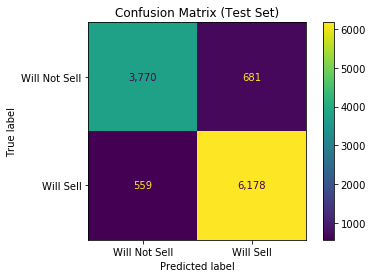

          | Train  | Test   |
          |-----------------|
Precision | 90.84% | 90.07% |
F1 Score  | 91.83% | 90.88% |
ROC-AUC   | 95.60% | 93.72% |


,Model,Precision,F1 Score,ROC-AUC
0,Vanilla Decision Tree,90.07%,90.88%,93.72%


In [14]:
sjs.evaluate('Vanilla Decision Tree', dt, X_train, X_test, y_train, y_test, use_decision_function='no')

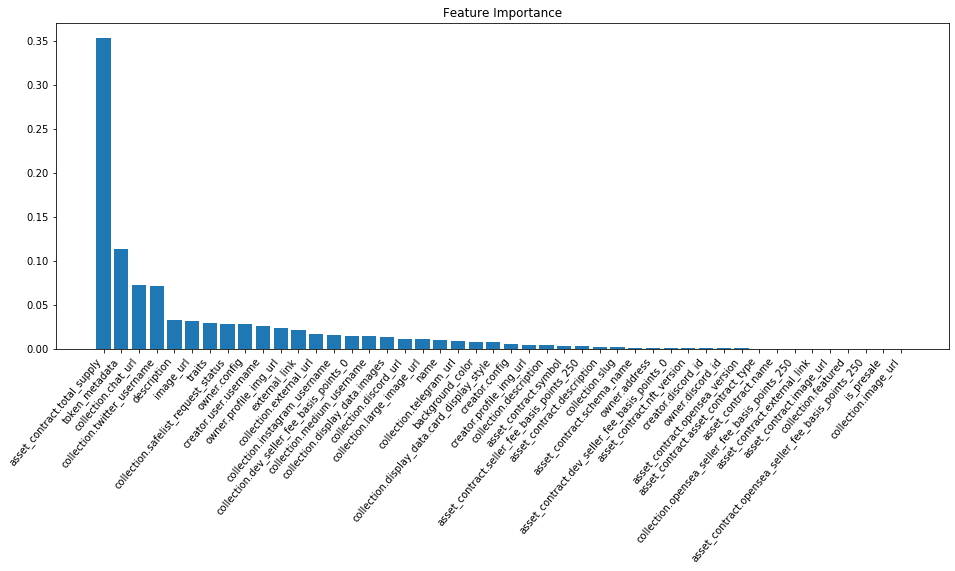

In [15]:
sjs.plot_feature_imp(dt, X)

In [16]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

## Decision Tree Tuned

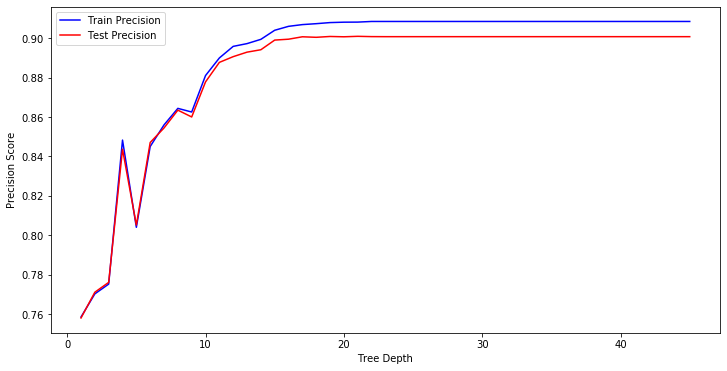

In [17]:
# Identify the optimal tree depth for given data

max_depths = list(range(1,46))
train_results = []
test_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)
    dt.fit(X_train, y_train)
    
    train_preds = dt.predict(X_train)
    p_score = precision_score(y_train, train_preds)
    # Add precision score to previous train results
    train_results.append(p_score)
    
    test_preds = dt.predict(X_test)
    p_score = precision_score(y_test, test_preds)
    # Add precision score to previous test results
    test_results.append(p_score)
    
plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train Precision')
plt.plot(max_depths, test_results, 'r', label='Test Precision')
plt.ylabel('Precision Score')
plt.xlabel('Tree Depth')
plt.legend()
plt.show()

In [ ]:
# will set max_depth to 46

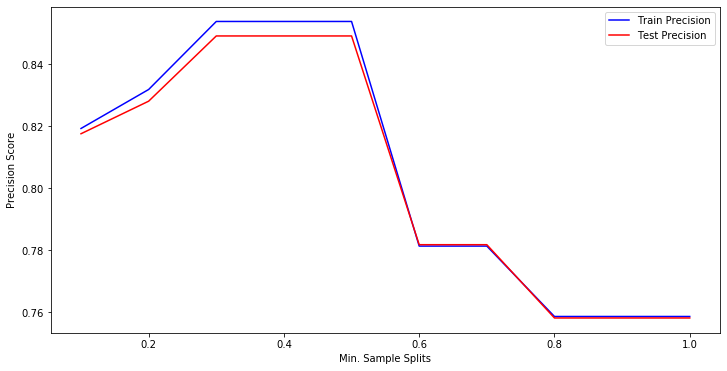

In [18]:
# Identify the optimal min-samples-split for given data

min_samples_splits = np.linspace(0.1, 1, 10, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=SEED)
    dt.fit(X_train, y_train)
    
    train_preds = dt.predict(X_train)
    p_score = precision_score(y_train, train_preds)
    # Add precision score to previous train results
    train_results.append(p_score)
    
    test_preds = dt.predict(X_test)
    p_score = precision_score(y_test, test_preds)
    # Add precision score to previous test results
    test_results.append(p_score)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train Precision')
plt.plot(min_samples_splits, test_results, 'r', label='Test Precision')
plt.ylabel('Precision Score')
plt.xlabel('Min. Sample Splits')
plt.legend()
plt.show()

In [ ]:
# will set min_samples_split = .3

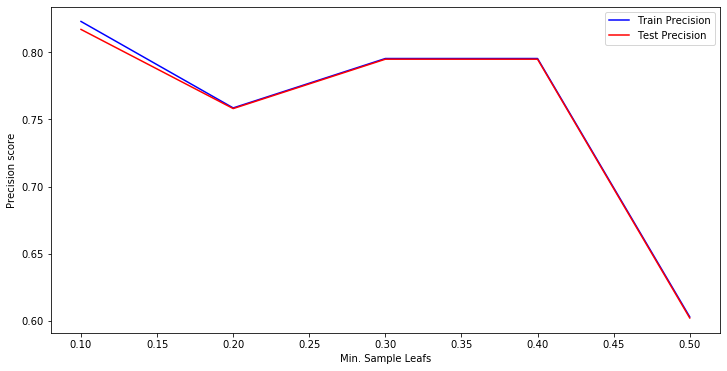

In [19]:
# Calculate the optimal value for minimum sample leafs

min_samples_leafs = np.linspace(.1, .5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=SEED)
    dt.fit(X_train, y_train)
    
    train_preds = dt.predict(X_train)
    p_score = precision_score(y_train, train_preds)
    # Add precision score to previous train results
    train_results.append(p_score)
    
    test_preds = dt.predict(X_test)
    p_score = precision_score(y_test, test_preds)
    # Add precision score to previous test results
    test_results.append(p_score)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train Precision')
plt.plot(min_samples_leafs, test_results, 'r', label='Test Precision')
plt.ylabel('Precision score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

In [ ]:
# will also set min_samples_leaf = .3

In [20]:
# Train a classifier with optimal values identified above

dt2 = DecisionTreeClassifier(max_depth=46, 
                             min_samples_split=.3, 
                             min_samples_leaf=.3, 
                             random_state=SEED
                            )

dt2.fit(X_train, y_train)
sjs.crossval(dt2, X_train, y_train)

Avg Precision Score of 0.7954 with Std Dev of 0.0011

The scores were: ['0.7971', '0.7946', '0.7940', '0.7954', '0.7956']


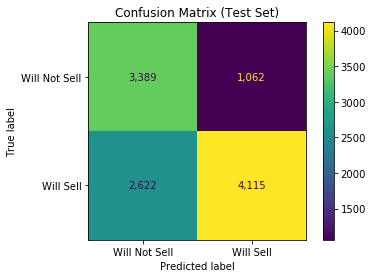

          | Train  | Test   |
          |-----------------|
Precision | 79.54% | 79.49% |
F1 Score  | 68.41% | 69.08% |
ROC-AUC   | 68.29% | 68.61% |


,Model,Precision,F1 Score,ROC-AUC
1,Tuned Decision Tree,79.49%,69.08%,68.61%
0,Vanilla Decision Tree,90.07%,90.88%,93.72%


In [21]:
sjs.evaluate('Tuned Decision Tree', dt2, X_train, X_test, y_train, y_test, use_decision_function='no')

In [ ]:
# very surprised that the scores went down so much. Will move to randodm forest for more generalizability 

## Random Forest

In [22]:
rf = RandomForestClassifier(random_state=SEED, verbose=2)
rf.fit(X_train, y_train)
sjs.crossval(rf, X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

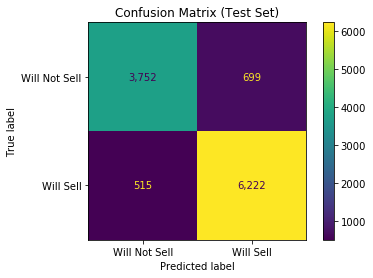

          | Train  | Test   |
          |-----------------|
Precision | 90.63% | 89.90% |
F1 Score  | 91.85% | 91.11% |
ROC-AUC   | 95.51% | 94.54% |


,Model,Precision,F1 Score,ROC-AUC
2,Random Forest,89.90%,91.11%,94.54%
1,Tuned Decision Tree,79.49%,69.08%,68.61%
0,Vanilla Decision Tree,90.07%,90.88%,93.72%


In [23]:
sjs.evaluate('Random Forest', rf, X_train, X_test, y_train, y_test, use_decision_function='no')

In [24]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 2,
 'warm_start': False}

In [ ]:
# closer to the original decision tree scores - in most params are the same

## Random Forest GS

In [25]:
rf2 = RandomForestClassifier(random_state=SEED)

param_grid = {'n_estimators' : [10, 100, 1000],
              'max_features' : [None, 'sqrt', 'log2']}

rf2_gs = GridSearchCV(rf2, param_grid, scoring='precision', cv=5, verbose=2)
rf2_gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .................max_features=None, n_estimators=10; total time=   1.4s
[CV] END .................max_features=None, n_estimators=10; total time=   1.2s
[CV] END .................max_features=None, n_estimators=10; total time=   0.5s
[CV] END .................max_features=None, n_estimators=10; total time=   0.4s
[CV] END .................max_features=None, n_estimators=10; total time=   0.6s
[CV] END ................max_features=None, n_estimators=100; total time=   3.5s
[CV] END ................max_features=None, n_estimators=100; total time=   3.5s
[CV] END ................max_features=None, n_estimators=100; total time=   3.8s
[CV] END ................max_features=None, n_estimators=100; total time=   4.5s
[CV] END ................max_features=None, n_estimators=100; total time=   4.5s
[CV] END ...............max_features=None, n_estimators=1000; total time=  35.9s
[CV] END ...............max_features=None, n_esti

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [10, 100, 1000]},
             scoring='precision', verbose=2)

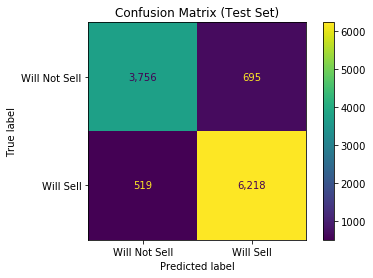

          | Train  | Test   |
          |-----------------|
Precision | 90.55% | 89.95% |
F1 Score  | 91.82% | 91.11% |
ROC-AUC   | 95.48% | 94.47% |


,Model,Precision,F1 Score,ROC-AUC
3,GS Random Forest,89.95%,91.11%,94.47%
2,Random Forest,89.90%,91.11%,94.54%
1,Tuned Decision Tree,79.49%,69.08%,68.61%
0,Vanilla Decision Tree,90.07%,90.88%,93.72%


In [26]:
sjs.evaluate('GS Random Forest', rf2_gs.best_estimator_, X_train, X_test, y_train, y_test, use_decision_function='no')

In [27]:
pprint(rf2_gs.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# again same params, except lower n_estimators

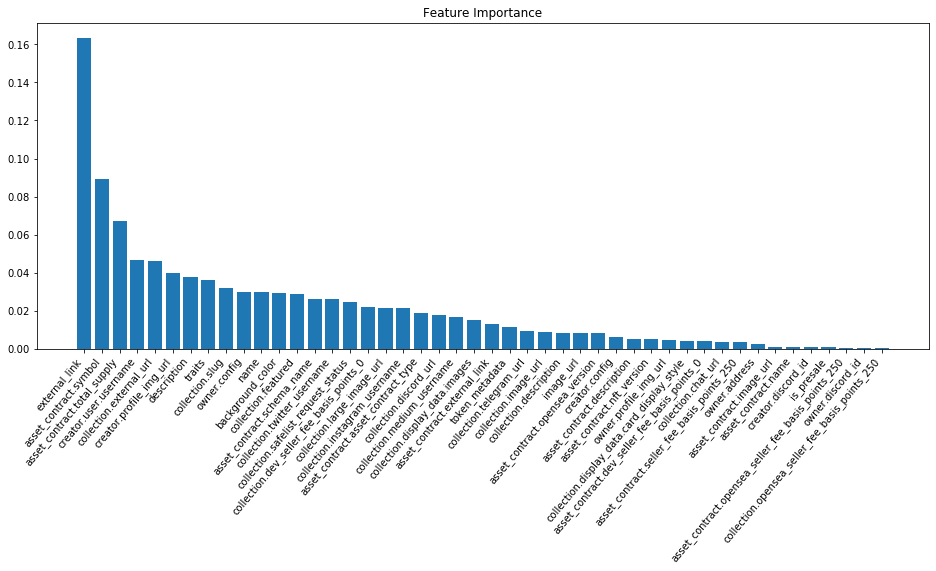

In [28]:
sjs.plot_feature_imp(rf2_gs.best_estimator_, X)

## Gradient Booster

In [29]:
GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)
sjs.crossval(GB, X_train, y_train)

Avg Precision Score of 0.8615 with Std Dev of 0.0055

The scores were: ['0.8628', '0.8665', '0.8602', '0.8664', '0.8515']


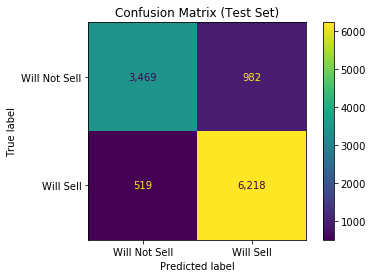

          | Train  | Test   |
          |-----------------|
Precision | 86.43% | 86.36% |
F1 Score  | 89.20% | 89.23% |
ROC-AUC   | 92.85% | 92.61% |


,Model,Precision,F1 Score,ROC-AUC
4,Gradient Boosting,86.36%,89.23%,92.61%
3,GS Random Forest,89.95%,91.11%,94.47%
2,Random Forest,89.90%,91.11%,94.54%
1,Tuned Decision Tree,79.49%,69.08%,68.61%
0,Vanilla Decision Tree,90.07%,90.88%,93.72%


In [30]:
sjs.evaluate('Gradient Boosting', GB, X_train, X_test, y_train, y_test, use_decision_function='no')

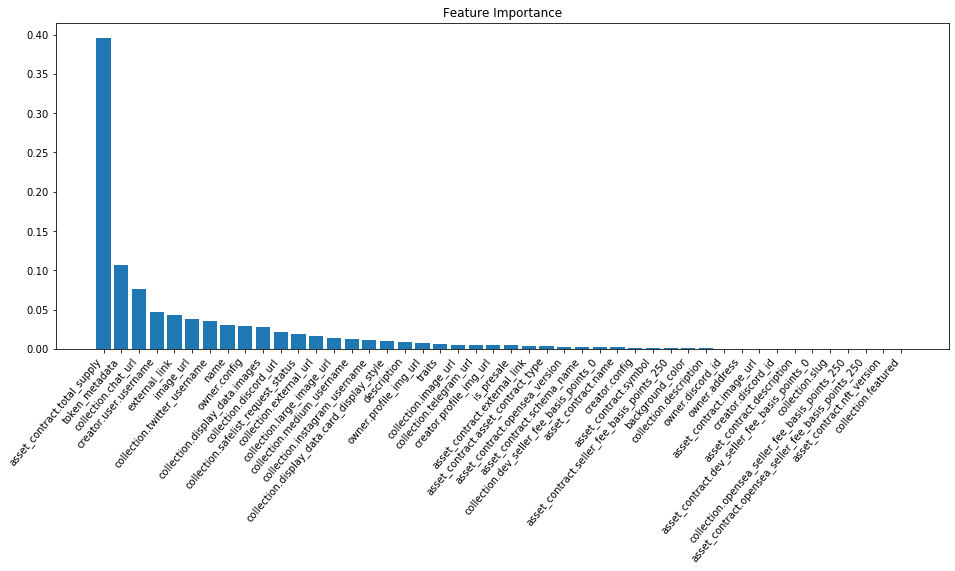

In [31]:
sjs.plot_feature_imp(GB, X)

## XG Boost

In [32]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
sjs.crossval(XGB, X_train, y_train)

Avg Precision Score of 0.8337 with Std Dev of 0.0023

The scores were: ['0.8368', '0.8334', '0.8339', '0.8346', '0.8297']


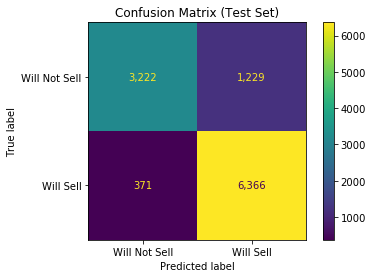

          | Train  | Test   |
          |-----------------|
Precision | 83.81% | 83.82% |
F1 Score  | 88.71% | 88.84% |
ROC-AUC   | 92.70% | 92.49% |


,Model,Precision,F1 Score,ROC-AUC
5,XGBoost,83.82%,88.84%,92.49%
4,Gradient Boosting,86.36%,89.23%,92.61%
3,GS Random Forest,89.95%,91.11%,94.47%
2,Random Forest,89.90%,91.11%,94.54%
1,Tuned Decision Tree,79.49%,69.08%,68.61%
0,Vanilla Decision Tree,90.07%,90.88%,93.72%


In [33]:
sjs.evaluate('XGBoost', XGB, X_train, X_test, y_train, y_test, use_decision_function='no')

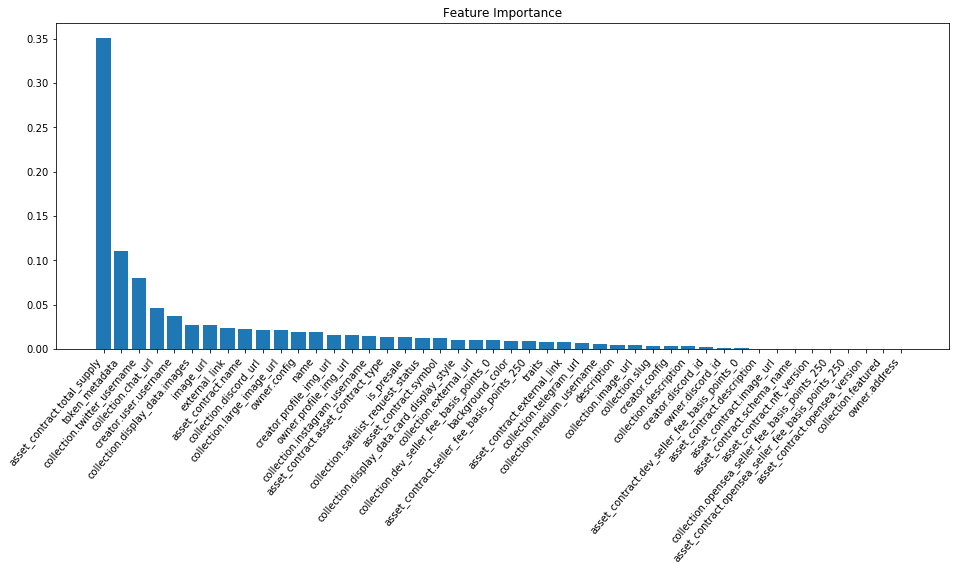

In [34]:
sjs.plot_feature_imp(XGB, X)

## KNN

In [35]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
sjs.crossval(knn, X_train, y_train)

Avg Precision Score of 0.8948 with Std Dev of 0.0089

The scores were: ['0.8966', '0.9007', '0.9011', '0.8985', '0.8773']


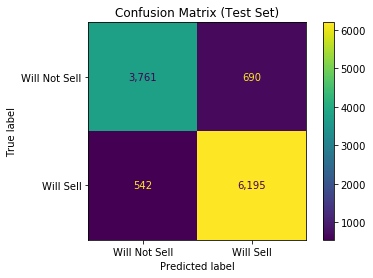

          | Train  | Test   |
          |-----------------|
Precision | 90.20% | 89.98% |
F1 Score  | 91.29% | 90.96% |
ROC-AUC   | 91.96% | 91.08% |


,Model,Precision,F1 Score,ROC-AUC
6,KNN,89.98%,90.96%,91.08%
5,XGBoost,83.82%,88.84%,92.49%
4,Gradient Boosting,86.36%,89.23%,92.61%
3,GS Random Forest,89.95%,91.11%,94.47%
2,Random Forest,89.90%,91.11%,94.54%
1,Tuned Decision Tree,79.49%,69.08%,68.61%
0,Vanilla Decision Tree,90.07%,90.88%,93.72%


In [36]:
sjs.evaluate('KNN', knn, X_train, X_test, y_train, y_test, use_decision_function='no')

In [ ]:
# because of the increased number of features in my data, not going to continue wiht KNN

## LogReg

In [37]:
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)
sjs.crossval(lr, X_train, y_train)

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-l

Avg Precision Score of 0.8303 with Std Dev of 0.0039

The scores were: ['0.8371', '0.8255', '0.8281', '0.8309', '0.8299']


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


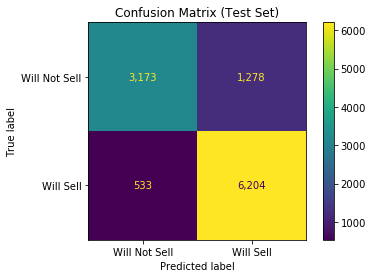

          | Train  | Test   |
          |-----------------|
Precision | 83.18% | 82.92% |
F1 Score  | 87.42% | 87.26% |
ROC-AUC   | 90.28% | 90.15% |


,Model,Precision,F1 Score,ROC-AUC
7,LogReg,82.92%,87.26%,90.15%
6,KNN,89.98%,90.96%,91.08%
5,XGBoost,83.82%,88.84%,92.49%
4,Gradient Boosting,86.36%,89.23%,92.61%
3,GS Random Forest,89.95%,91.11%,94.47%
2,Random Forest,89.90%,91.11%,94.54%
1,Tuned Decision Tree,79.49%,69.08%,68.61%
0,Vanilla Decision Tree,90.07%,90.88%,93.72%


In [38]:
sjs.evaluate('LogReg', lr, X_train, X_test, y_train, y_test, use_decision_function='yes')

## LogReg GS

In [39]:
lr2 = LogisticRegression()

param_grid = {'penalty' : ['l1', 'l2'],
              'C' : [100, 10, 1.0, 0.1, 0.01],
              'class_weight': [None, 'balanced'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear']}

lr_gs = GridSearchCV(lr2, param_grid, scoring='precision', cv=5, verbose=2)
lr_gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END C=100, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   7.1s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   5.6s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   9.2s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   6.4s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   5.5s
[CV] END C=100, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END C=100, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END C=100, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END C=100, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.2s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=100, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=100, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=100, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=100, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=100, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=l

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=   7.2s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=   7.7s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=  14.6s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=   8.7s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=   7.6s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.2s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=10, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=l1, solver=lbfgs;

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   7.3s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   7.2s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   5.4s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   6.6s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   6.7s
[CV] END C=10, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.9s
[CV] END C=10, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END C=10, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END C=10, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.8s
[CV] END C=10, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.9s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ..C=10, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.6s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ..C=10, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.4s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ..C=10, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ..C=10, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ..C=10, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=lbfgs; total

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=  10.8s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=   7.5s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=  10.7s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=   6.8s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=  10.2s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.9s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.9s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=1.0, class_weight=None, penalty=l1, solver=lbfgs; 

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=1.0, class_weight=None, penalty=l1, solver=liblinear; total time=   9.3s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=liblinear; total time=   8.9s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=liblinear; total time=  12.1s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=liblinear; total time=   9.2s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=liblinear; total time=   8.7s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.6s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=1.0, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=1.0, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=1.0, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.2s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=1.0, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=1.0, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=l

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=liblinear; total time=   9.8s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=liblinear; total time=  10.4s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=liblinear; total time=  12.0s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=liblinear; total time=  10.1s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=liblinear; total time=  11.6s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.6s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=0.1, class_weight=None, penalty=l1, solver=l

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=   2.4s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=   2.4s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=   2.2s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=   3.7s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=   2.1s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.4s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.2s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.2s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   2.6s
[CV] END C=0.1, class_weight=balanced, penalty=l1, s

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, sol

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total t

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END C=0.01, class_we

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.83057351 0.83061053 0.83139156 0.83061053
        nan        nan 0.87073461 0.87060756 0.87040383 0.87074062
        nan        nan 0.83046062 0.83038162 0.83086083 0.83045435
        nan        nan 0.87067996 0.87065361 0.86979757 0.87059053
        nan        nan 0.82966982 0.82977428 0.83030041 0.82977487
        nan        nan 0.87036202 0.87040229 0.86967739 0.87028036
        nan        nan 0.82798487 0.8282765  0.82842352 0.83420844
        nan        nan 0.85367312 0.85327248 0.8523094  0.8504685
        nan        nan 0.79662    0.81911252 0.81911252 0.82519871
        nan        nan 0.83833232 0.83439549 0.83438059 0.8324433 ]
  category=UserWarning


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='precision', verbose=2)

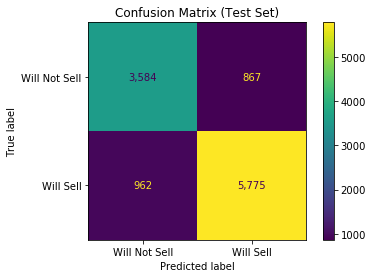

          | Train  | Test   |
          |-----------------|
Precision | 86.99% | 86.95% |
F1 Score  | 86.60% | 86.33% |
ROC-AUC   | 90.31% | 90.13% |


,Model,Precision,F1 Score,ROC-AUC
8,GS LogReg,86.95%,86.33%,90.13%
7,LogReg,82.92%,87.26%,90.15%
6,KNN,89.98%,90.96%,91.08%
5,XGBoost,83.82%,88.84%,92.49%
4,Gradient Boosting,86.36%,89.23%,92.61%
3,GS Random Forest,89.95%,91.11%,94.47%
2,Random Forest,89.90%,91.11%,94.54%
1,Tuned Decision Tree,79.49%,69.08%,68.61%
0,Vanilla Decision Tree,90.07%,90.88%,93.72%


In [40]:
sjs.evaluate('GS LogReg', lr_gs.best_estimator_, X_train, X_test, y_train, y_test, use_decision_function='yes')

In [41]:
lr_gs.best_params_   

{'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

In [42]:
# Check for Multicollinearity

In [43]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [44]:
X = df.iloc[:,:-3]

In [45]:
pd.options.display.float_format = '{:.2f}'.format
calc_vif(X).sort_values(by=['VIF'], ascending=False)

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
7,asset_contract.asset_contract_type,inf
8,asset_contract.schema_name,inf
5,asset_contract.opensea_seller_fee_basis_points...,45327.97
18,asset_contract.image_url,3602.52
9,asset_contract.name,2289.37
30,collection.image_url,1457.88
2,asset_contract.dev_seller_fee_basis_points_0,1076.21
20,asset_contract.opensea_version,1041.38
4,asset_contract.seller_fee_basis_points_250,929.78
0,is_presale,622.51


In [ ]:
# if I want to continue with LogReg, will need to deal with multicollinearity
# particularly because interpretability and feature importance is part of my business problem

# Evaluate on New Test Data

In [ ]:
# several weeks after beginning the original data gathering, 
# I ran the same code again and (see notebook linked below)
# with same processing and removed duplicates to create a true
# test set with 20k+ new rows of data

[Notebook for creating Test Set](notebooks/new_test_data)

## Import Test Data

In [6]:
parse_dates = ['asset_contract.created_date', 'collection.created_date']
df_test = pd.read_csv('data/nft_binary2_test_set.csv', low_memory=False, parse_dates=parse_dates)

In [47]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26241 entries, 0 to 26240
Data columns (total 49 columns):
is_presale                                            26241 non-null int64
collection.featured                                   26241 non-null int64
asset_contract.dev_seller_fee_basis_points_0          26241 non-null int64
collection.dev_seller_fee_basis_points_0              26241 non-null int64
asset_contract.seller_fee_basis_points_250            26241 non-null int64
asset_contract.opensea_seller_fee_basis_points_250    26241 non-null int64
collection.opensea_seller_fee_basis_points_250        26241 non-null int64
asset_contract.asset_contract_type                    26241 non-null int64
asset_contract.schema_name                            26241 non-null int64
asset_contract.name                                   26241 non-null int64
collection.safelist_request_status                    26241 non-null int64
collection.slug                                       26241 non-nu

In [7]:
# Define our test X and y and run similar models using complete data from before as training
X_test_new = df_test.drop(columns=['asset_contract.created_date', 'collection.created_date', 'target'])
y_test_new = df_test['target']

## Decision Tree

In [8]:
dt3 = DecisionTreeClassifier(random_state=SEED)
dt3.fit(X, y)
sjs.crossval(dt3, X, y)

Avg Precision Score of 0.8694 with Std Dev of 0.0917

The scores were: ['0.8826', '0.7254', '0.8231', '0.9985', '0.9172']


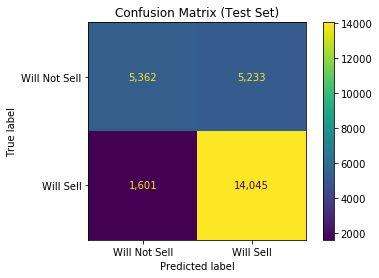

          | Train  | Test   |
          |-----------------|
Precision | 90.80% | 72.86% |
F1 Score  | 91.79% | 80.43% |
ROC-AUC   | 95.53% | 83.22% |


,Model,Precision,F1 Score,ROC-AUC
0,Decision Tree - Test,72.86%,80.43%,83.22%


In [9]:
sjs.evaluate('Decision Tree - Test', dt3, X, X_test_new, y, y_test_new, use_decision_function='no')

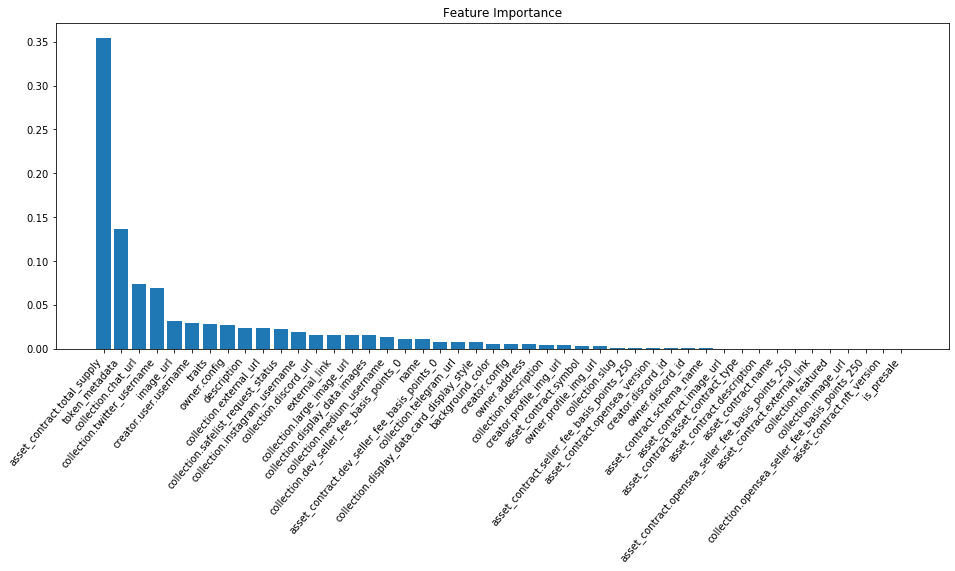

In [10]:
sjs.plot_feature_imp(dt3, X)

## Random Forest GS

In [52]:
rf3 = RandomForestClassifier(random_state=SEED)

param_grid = {'n_estimators' : [10, 100, 1000],
              'max_features' : [None, 'sqrt', 'log2']}

rf3_gs = GridSearchCV(rf2, param_grid, scoring='precision', cv=5, verbose=2)
rf3_gs.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .................max_features=None, n_estimators=10; total time=   0.4s
[CV] END .................max_features=None, n_estimators=10; total time=   0.6s
[CV] END .................max_features=None, n_estimators=10; total time=   0.6s
[CV] END .................max_features=None, n_estimators=10; total time=   0.6s
[CV] END .................max_features=None, n_estimators=10; total time=   0.6s
[CV] END ................max_features=None, n_estimators=100; total time=   7.8s
[CV] END ................max_features=None, n_estimators=100; total time=   7.2s
[CV] END ................max_features=None, n_estimators=100; total time=   4.5s
[CV] END ................max_features=None, n_estimators=100; total time=   4.2s
[CV] END ................max_features=None, n_estimators=100; total time=   4.3s
[CV] END ...............max_features=None, n_estimators=1000; total time=  39.7s
[CV] END ...............max_features=None, n_esti

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [10, 100, 1000]},
             scoring='precision', verbose=2)

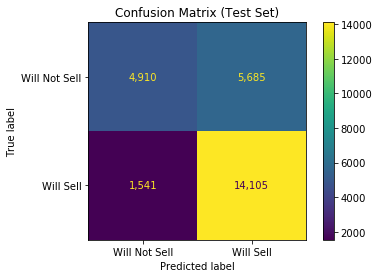

          | Train  | Test   |
          |-----------------|
Precision | 90.63% | 71.27% |
F1 Score  | 91.81% | 79.61% |
ROC-AUC   | 95.45% | 87.11% |


,Model,Precision,F1 Score,ROC-AUC
10,GS Random Forest - Test,71.27%,79.61%,87.11%
9,Decision Tree - Test,72.86%,80.43%,83.22%
8,GS LogReg,86.95%,86.33%,90.13%
7,LogReg,82.92%,87.26%,90.15%
6,KNN,89.98%,90.96%,91.08%
5,XGBoost,83.82%,88.84%,92.49%
4,Gradient Boosting,86.36%,89.23%,92.61%
3,GS Random Forest,89.95%,91.11%,94.47%
2,Random Forest,89.90%,91.11%,94.54%
1,Tuned Decision Tree,79.49%,69.08%,68.61%


In [53]:
sjs.evaluate('GS Random Forest - Test', rf3_gs.best_estimator_, X, X_test_new, y, y_test_new, use_decision_function='no')

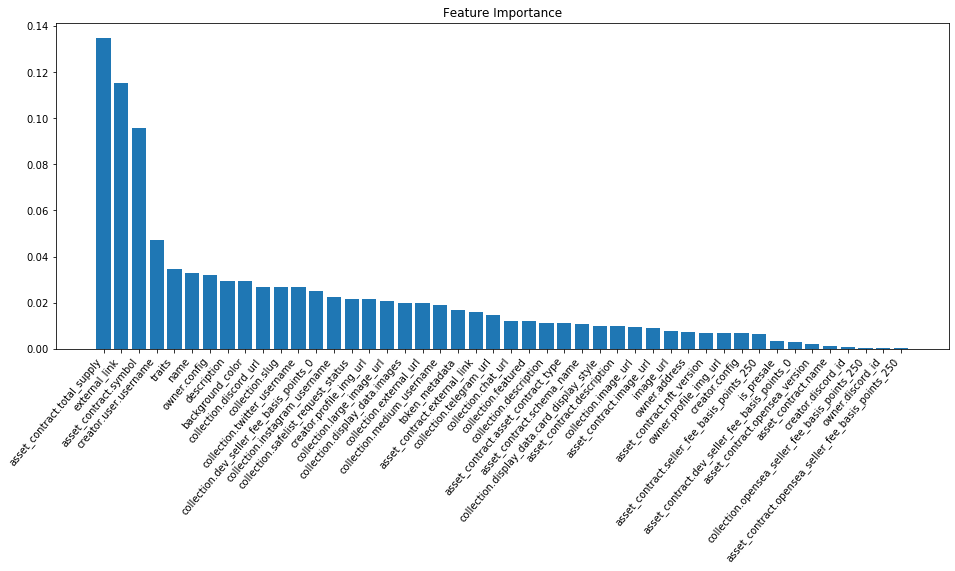

In [54]:
sjs.plot_feature_imp(rf3_gs.best_estimator_, X)

## Gradient Booster

In [55]:
GB2 = GradientBoostingClassifier()
GB2.fit(X, y)
sjs.crossval(GB2, X, y)

Avg Precision Score of 0.8431 with Std Dev of 0.1216

The scores were: ['0.7601', '0.6725', '0.8252', '0.9980', '0.9596']


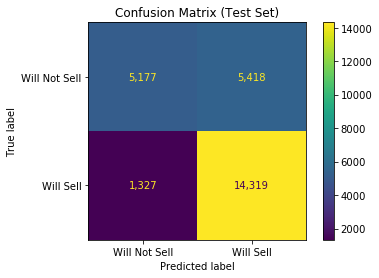

          | Train  | Test   |
          |-----------------|
Precision | 86.45% | 72.55% |
F1 Score  | 89.27% | 80.94% |
ROC-AUC   | 92.85% | 85.10% |


,Model,Precision,F1 Score,ROC-AUC
11,Gradient Booster - Test,72.55%,80.94%,85.10%
10,GS Random Forest - Test,71.27%,79.61%,87.11%
9,Decision Tree - Test,72.86%,80.43%,83.22%
8,GS LogReg,86.95%,86.33%,90.13%
7,LogReg,82.92%,87.26%,90.15%
6,KNN,89.98%,90.96%,91.08%
5,XGBoost,83.82%,88.84%,92.49%
4,Gradient Boosting,86.36%,89.23%,92.61%
3,GS Random Forest,89.95%,91.11%,94.47%
2,Random Forest,89.90%,91.11%,94.54%


In [56]:
sjs.evaluate('Gradient Booster - Test', GB2, X, X_test_new, y, y_test_new, use_decision_function='no')

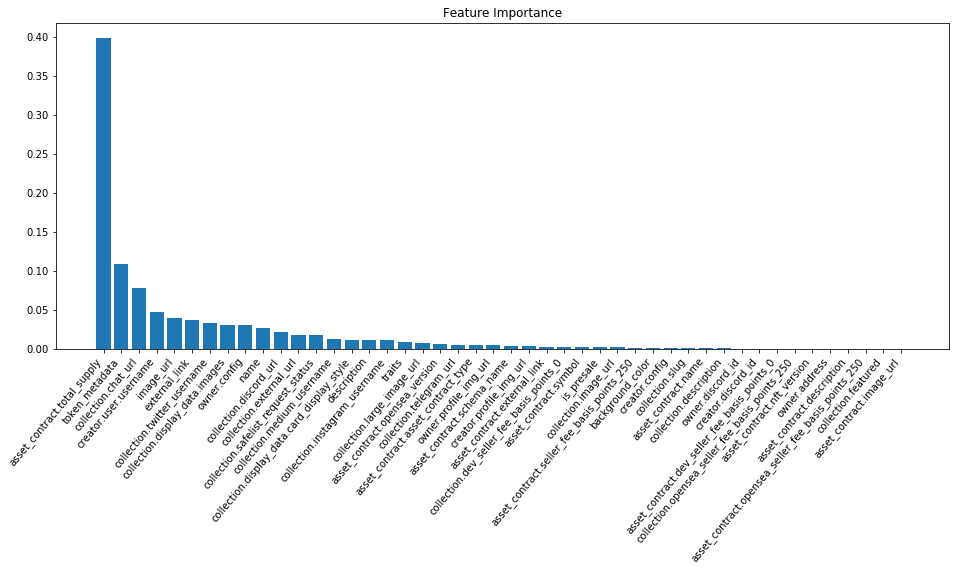

In [57]:
sjs.plot_feature_imp(GB2, X)

## KNN

In [58]:
knn2 = KNeighborsClassifier()
knn2.fit(X, y)
sjs.crossval(knn2, X, y)

Avg Precision Score of 0.8736 with Std Dev of 0.1039

The scores were: ['0.8510', '0.7189', '0.8206', '0.9982', '0.9794']


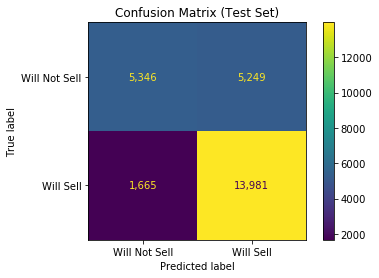

          | Train  | Test   |
          |-----------------|
Precision | 88.15% | 72.70% |
F1 Score  | 91.05% | 80.18% |
ROC-AUC   | 92.74% | 83.45% |


,Model,Precision,F1 Score,ROC-AUC
12,KNN - Test,72.70%,80.18%,83.45%
11,Gradient Booster - Test,72.55%,80.94%,85.10%
10,GS Random Forest - Test,71.27%,79.61%,87.11%
9,Decision Tree - Test,72.86%,80.43%,83.22%
8,GS LogReg,86.95%,86.33%,90.13%
7,LogReg,82.92%,87.26%,90.15%
6,KNN,89.98%,90.96%,91.08%
5,XGBoost,83.82%,88.84%,92.49%
4,Gradient Boosting,86.36%,89.23%,92.61%
3,GS Random Forest,89.95%,91.11%,94.47%


In [59]:
sjs.evaluate('KNN - Test', knn2, X, X_test_new, y, y_test_new, use_decision_function='no')

## LogReg GS

In [60]:
lr3 = LogisticRegression()

param_grid = {'penalty' : ['l1', 'l2'],
              'C' : [100, 10, 1.0, 0.1, 0.01],
              'class_weight': [None, 'balanced'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear']}

lr3_gs = GridSearchCV(lr3, param_grid, scoring='precision', cv=5, verbose=2)
lr3_gs.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END C=100, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=100, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=  12.7s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=  10.9s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=  10.1s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=  13.8s
[CV] END C=100, class_weight=None, penalty=l1, solver=liblinear; total time=   8.7s
[CV] END C=100, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END C=100, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.7s
[CV] END C=100, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.7s
[CV] END C=100, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.6s
[CV] END C=100, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.6s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=100, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=100, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=100, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=100, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=100, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   1.1s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   1.4s
[CV] END C=100, class_weight=None, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=l

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=  12.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=  10.1s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=  10.6s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=  11.3s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=liblinear; total time=  26.7s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   2.3s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   2.9s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.7s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.9s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.7s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.4s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.9s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.9s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.9s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.9s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   1.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=l1, solver=lbfgs;

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   9.1s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=  10.7s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   8.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=  12.2s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   8.7s
[CV] END C=10, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.4s
[CV] END C=10, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.1s
[CV] END C=10, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=10, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=10, class_weight=None, penalty=l2, solver=newton-cg; total time=   1.1s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ..C=10, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ..C=10, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ..C=10, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ..C=10, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END ..C=10, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=10, class_weight=None, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=lbfgs; total

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=   7.2s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=  11.9s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=  12.4s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=  15.7s
[CV] END C=10, class_weight=balanced, penalty=l1, solver=liblinear; total time=  15.3s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.3s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.2s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   1.1s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.6s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=1.0, class_weight=None, penalty=l1, solver=lbfgs; 

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=1.0, class_weight=None, penalty=l1, solver=liblinear; total time=  16.4s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=liblinear; total time=  15.7s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=liblinear; total time=  19.7s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=liblinear; total time=   9.9s
[CV] END C=1.0, class_weight=None, penalty=l1, solver=liblinear; total time=  12.4s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.9s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.7s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.8s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=1.0, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=1.0, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=1.0, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=1.0, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.4s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=1.0, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1.0, class_weight=None, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=l

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=liblinear; total time=  23.1s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=liblinear; total time=  14.2s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=liblinear; total time=  22.1s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=liblinear; total time=  12.9s
[CV] END C=1.0, class_weight=balanced, penalty=l1, solver=liblinear; total time=  12.4s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.8s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.7s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.4s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=1.0, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .C=0.1, class_weight=None, penalty=l1, solver=l

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=   3.8s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=   4.4s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=   7.1s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=   4.4s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=   1.9s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.5s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.5s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.5s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.4s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.4s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END .C=0.1, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=l

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   6.2s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   5.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   8.5s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   4.9s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   4.4s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.6s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=newton-cg; total time=   0.5s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.4s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.4s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.4s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, sol

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total t

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shawn/opt/anaconda3/envs/learn

[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   1.4s
[CV] END C=0.01, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.9s
[CV] END C=0.01, class_weight=balanced, p

/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.2s


/Users/shawn/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.80518444 0.80387717 0.80465005 0.80387717
        nan        nan 0.82081424 0.82083252 0.82041241 0.82083252
        nan        nan 0.80518483 0.80382034 0.80498165 0.80384763
        nan        nan 0.82082328 0.82081486 0.81360512 0.82071992
        nan        nan 0.80506263 0.80510671 0.80845391 0.80521845
        nan        nan 0.81350279 0.81370562 0.81362138 0.8136693
        nan        nan 0.79693921 0.80625369 0.80631844 0.80166914
        nan        nan 0.81303364 0.81274226 0.8117534  0.81287156
        nan        nan 0.79063735 0.79895493 0.79895493 0.79799701
        nan        nan 0.80265434 0.81704527 0.81704527 0.81065817]
  category=UserWarning


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='precision', verbose=2)

In [61]:
lr3_gs.best_estimator_.get_params()

{'C': 100,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

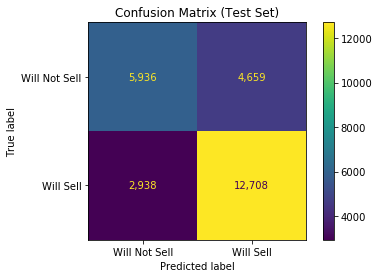

          | Train  | Test   |
          |-----------------|
Precision | 86.94% | 73.17% |
F1 Score  | 86.50% | 76.99% |
ROC-AUC   | 90.33% | 78.73% |


,Model,Precision,F1 Score,ROC-AUC
13,GS LogReg - Test,73.17%,76.99%,78.73%
12,KNN - Test,72.70%,80.18%,83.45%
11,Gradient Booster - Test,72.55%,80.94%,85.10%
10,GS Random Forest - Test,71.27%,79.61%,87.11%
9,Decision Tree - Test,72.86%,80.43%,83.22%
8,GS LogReg,86.95%,86.33%,90.13%
7,LogReg,82.92%,87.26%,90.15%
6,KNN,89.98%,90.96%,91.08%
5,XGBoost,83.82%,88.84%,92.49%
4,Gradient Boosting,86.36%,89.23%,92.61%


In [62]:
sjs.evaluate('GS LogReg - Test', lr3_gs.best_estimator_, X, X_test_new, y, y_test_new, use_decision_function='yes')

In [63]:
coef_dict = {}
for coef, feat in zip(lr3_gs.best_estimator_.coef_[0,:],X.columns):
    coef_dict[feat] = coef

In [64]:
pd.DataFrame.from_dict(coef_dict, orient='index', columns=['coef']).sort_values(by=['coef'], ascending=False)

,coef
owner.discord_id,3.30
collection.slug,2.83
collection.image_url,2.41
asset_contract.nft_version,1.98
token_metadata,1.77
asset_contract.symbol,1.67
creator.user.username,1.25
collection.instagram_username,1.02
external_link,0.98
collection.twitter_username,0.78


In [ ]:
# overall more consistent scores across models

# Final Model

In [ ]:
# will create a final decision tree model that is 
# trained on all the data with cross-validation of scores

## Combine Train, Validation & Test Sets

In [11]:
df_full = pd.concat([df, df_test], ignore_index=True)

In [12]:
df_full.head()

,is_presale,collection.featured,asset_contract.dev_seller_fee_basis_points_0,collection.dev_seller_fee_basis_points_0,asset_contract.seller_fee_basis_points_250,asset_contract.opensea_seller_fee_basis_points_250,collection.opensea_seller_fee_basis_points_250,asset_contract.asset_contract_type,asset_contract.schema_name,asset_contract.name,...,description,external_link,image_url,name,owner.config,owner.discord_id,token_metadata,asset_contract.created_date,collection.created_date,target
0,1,0,1,0,1,1,1,0,0,1,...,0,1,1,1,0,0,0,2020-12-02 17:40:53.232025,2021-06-10 01:49:35.180218,0
1,1,0,1,0,1,1,1,0,0,1,...,1,0,1,1,0,0,0,2020-12-02 17:40:53.232025,2021-05-03 18:55:32.762585,0
2,1,0,1,1,1,1,1,0,0,1,...,1,0,1,1,0,0,0,2020-12-02 17:40:53.232025,2021-05-19 07:24:46.125544,0
3,1,0,1,1,1,1,1,0,0,1,...,1,0,1,1,0,0,0,2020-12-02 17:40:53.232025,2021-06-29 12:49:00.283468,0
4,1,0,1,0,1,1,1,0,0,1,...,0,0,1,1,0,0,0,2020-12-02 17:40:53.232025,2021-05-30 16:45:39.254227,0


In [13]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70993 entries, 0 to 70992
Data columns (total 49 columns):
is_presale                                            70993 non-null int64
collection.featured                                   70993 non-null int64
asset_contract.dev_seller_fee_basis_points_0          70993 non-null int64
collection.dev_seller_fee_basis_points_0              70993 non-null int64
asset_contract.seller_fee_basis_points_250            70993 non-null int64
asset_contract.opensea_seller_fee_basis_points_250    70993 non-null int64
collection.opensea_seller_fee_basis_points_250        70993 non-null int64
asset_contract.asset_contract_type                    70993 non-null int64
asset_contract.schema_name                            70993 non-null int64
asset_contract.name                                   70993 non-null int64
collection.safelist_request_status                    70993 non-null int64
collection.slug                                       70993 non-nu

## Train Final Model

In [14]:
# Define X & y
X_final = df_full.drop(columns=['asset_contract.created_date', 'collection.created_date', 'target'])
y_final = df_full['target']

In [15]:
dt4 = DecisionTreeClassifier(random_state=SEED)
dt4.fit(X_final, y_final)
sjs.crossval(dt3, X_final, y_final, cv=10)

Avg Precision Score of 0.8750 with Std Dev of 0.1142

The scores were: ['0.8877', '0.8540', '0.6602', '0.9921', '0.9987', '0.9923', '0.9297', '0.9334', '0.7938', '0.7079']


## Train Final Model w/Shuffling

In [16]:
# I have a feeling that the order of the initial dataset is affecting the cross validation
# to experiment, I will shuffle the rows

In [17]:
X_shuff = X_final.sample(frac = 1, random_state=SEED)
y_shuff = y_final.sample(frac = 1, random_state=SEED)

In [18]:
dt5 = DecisionTreeClassifier(random_state=SEED)
dt5.fit(X_shuff, y_shuff)
sjs.crossval(dt5, X_shuff, y_shuff, cv=10)

Avg Precision Score of 0.9126 with Std Dev of 0.0027

The scores were: ['0.9167', '0.9155', '0.9094', '0.9114', '0.9139', '0.9138', '0.9110', '0.9142', '0.9129', '0.9073']


In [19]:
# happy with this crossvalidated average score

# Feature Importance

In [ ]:
# I will use feature importance plot, SkopeRules and SHAP to aggregate feature importance data

## Feature Importance Plot

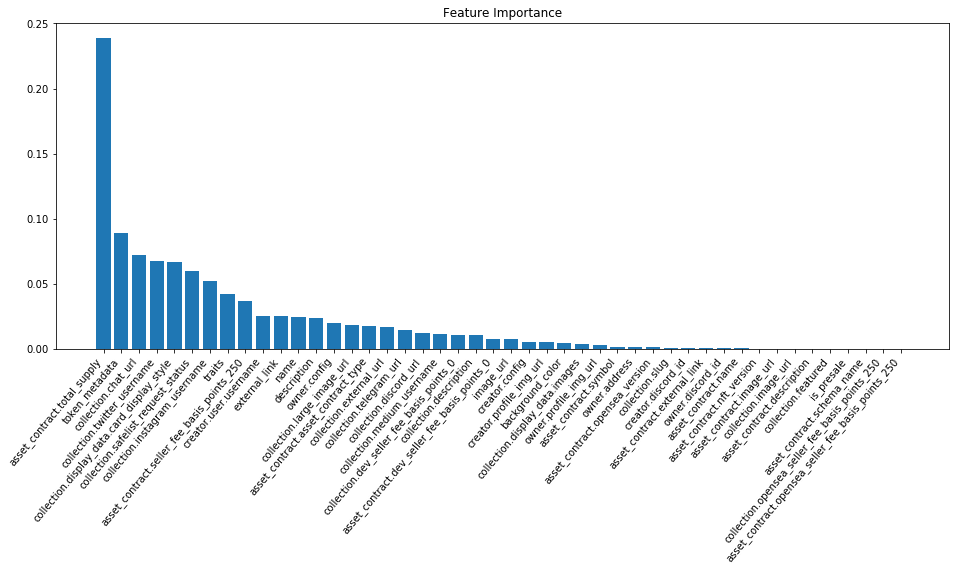

In [20]:
sjs.plot_feature_imp(dt5, X_shuff)

In [21]:
# Top 5 features are:

#1 asset_contract.total_supply
#2 token_metadata
#3 collection.chat_url
#4 collection.twitter_username  
#5 collection.display_data.card_display_style  

## SkopeRule

In [22]:
# code borrowed from documentation example case found here: 
# https://skope-rules.readthedocs.io/en/latest/auto_examples/plot_credit_default.html#getting-rules-with-skrules

In [23]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules
from sklearn.metrics import roc_curve, precision_recall_curve

In [24]:
sr = SkopeRules(feature_names=X_shuff.columns, max_depth=None, random_state=SEED, verbose=2)
sr.fit(X_shuff,y_shuff)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...
Building estimator 1 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


SkopeRules(feature_names=Index(['is_presale', 'collection.featured',
       'asset_contract.dev_seller_fee_basis_points_0',
       'collection.dev_seller_fee_basis_points_0',
       'asset_contract.seller_fee_basis_points_250',
       'asset_contract.opensea_seller_fee_basis_points_250',
       'collection.opensea_seller_fee_basis_points_250',
       'asset_contract.asset_contract_type', 'asset_co...
       'collection.image_url', 'collection.instagram_username',
       'collection.large_image_url', 'collection.medium_username',
       'collection.telegram_url', 'collection.twitter_username',
       'creator.config', 'creator.discord_id', 'creator.user.username',
       'description', 'external_link', 'image_url', 'name', 'owner.config',
       'owner.discord_id', 'token_metadata'],
      dtype='object'),
           max_depth=None, random_state=42, verbose=2)

### Plot

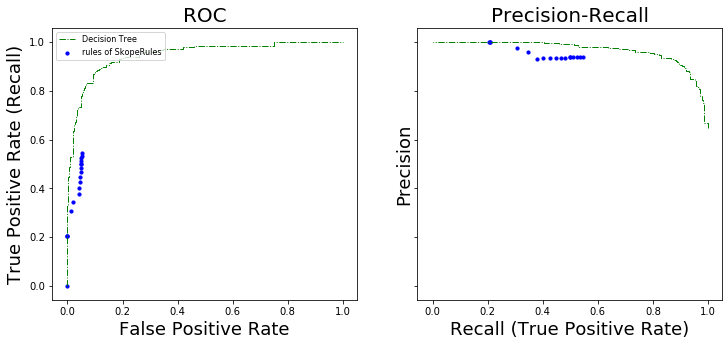

In [25]:
scoring_dt5 = dt5.predict_proba(X_shuff)[:, 1]

scoring = sr.score_top_rules(X_shuff)

curves = [roc_curve, precision_recall_curve]
xlabels = ['False Positive Rate', 'Recall (True Positive Rate)']
ylabels = ['True Positive Rate (Recall)', 'Precision']


fig, axes = plt.subplots(1, 2, figsize=(12, 5),
                         sharex=True, sharey=True)

ax = axes[0]
fpr, tpr, _ = roc_curve(y_shuff, scoring)
fpr_dt5, tpr_dt5, _ = roc_curve(y_shuff, scoring_dt5)
ax.scatter(fpr[:-1], tpr[:-1], c='b', s=10, label="rules of SkopeRules")
ax.step(fpr_dt5, tpr_dt5, linestyle='-.', c='g', lw=1, where='post',
        label="Decision Tree")
ax.set_title("ROC", fontsize=20)
ax.legend(loc='upper left', fontsize=8)
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=18)

ax = axes[1]
precision, recall, _ = precision_recall_curve(y_shuff, scoring)
precision_dt5, recall_dt5, _ = precision_recall_curve(y_shuff, scoring_dt5)
ax.scatter(recall[1:-1], precision[1:-1], c='b', s=10,
           label="rules of SkopeRules")
ax.step(recall_dt5, precision_dt5, linestyle='-.', c='g', lw=1, where='post',
        label="Decision Tree")
ax.set_title("Precision-Recall", fontsize=20)
ax.set_xlabel('Recall (True Positive Rate)', fontsize=18)
ax.set_ylabel('Precision', fontsize=18)
plt.show()

### Rules

In [26]:
print(str(len(sr.rules_)) + ' rules have been built.')
print('The 5 most precise rules are the following:')
print
for rule in sr.rules_[:5]:
    print(rule[0])
    print("")

85 rules have been built.
The 5 most precise rules are the following:
asset_contract.description <= 0.5 and asset_contract.total_supply <= 0.5 and collection.display_data.card_display_style <= 0.5 and image_url <= 0.5 and token_metadata <= 0.5

asset_contract.total_supply <= 0.5 and collection.display_data.card_display_style <= 0.5 and collection.large_image_url <= 0.5 and name <= 0.5 and token_metadata <= 0.5

asset_contract.total_supply <= 0.5 and collection.description <= 0.5 and collection.display_data.card_display_style <= 0.5 and collection.display_data.images > 0.5 and name <= 0.5

asset_contract.total_supply <= 0.5 and collection.display_data.card_display_style <= 0.5 and name <= 0.5 and token_metadata <= 0.5

asset_contract.total_supply <= 0.5 and collection.display_data.card_display_style <= 0.5 and collection.large_image_url <= 0.5 and image_url <= 0.5 and token_metadata <= 0.5



In [27]:
# Based on the top 5 rules, the following columns showed up the most:  
  
# asset_contract.total_supply - 5x
# collection.display_data.card_display_style - 5x 
# token_metadata - 4x
# name - 3x
# image_url - 3x
# collection.large_image_url - 2x
# asset_contract.description - 1x
# collection.description - 1x
# collection.display_data.images - 1x

## Shap

In [28]:
import shap

In [29]:
explainer = shap.TreeExplainer(dt5)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [36]:
# looking at a single row
rows_to_eval = X_shuff[1:2]
shap_values = explainer.shap_values(rows_to_eval, check_additivity=False)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], rows_to_eval)

In [37]:
# looking at multiple rows
rows_to_eval = X_shuff[:100]
shap_values = explainer.shap_values(rows_to_eval, check_additivity=False)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], rows_to_eval)

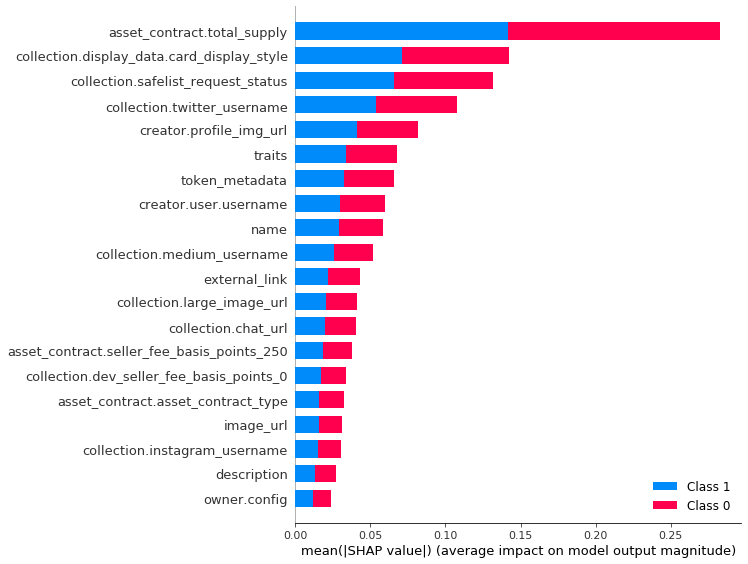

In [38]:
# summarize all shap values
shap_values = explainer.shap_values(X_shuff, check_additivity=False)
shap.summary_plot(shap_values, X_shuff)

## Feature Summary

##### Combining results of Skope, SHAP and dt3 feature importance plot  
1. dt5 # indicates the ranking in the dt3 feature importance plot
2. Skope indicates # of occurences in the top 5 decision rules  
3. SHAP # indicates the ranking of SHAP valeus


                         asset_contract.total_supply | dt5 #1 | Skope 5x | SHAP #1 | ***   
                                      token_metadata | dt5 #2 | Skope 4x | SHAP #7 | *** 
                                 collection.chat_url | dt5 #3 |          |         |
                         collection.twitter_username | dt5 #4 |          | SHAP #4 |     
          collection.display_data.card_display_style | dt5 #5 | Skope 5x | SHAP #2 | ***    
                                           image_url |        | Skope 3x |         |   
                  collection.safelist_request_status |        |          | SHAP #3 | 
                             creator.profile_img_url |        |          | SHAP #5 | 
                                              traits |        |          | SHAP #6 |    

# Pickle Model

In [86]:
import pickle

# save the model to disk
filename = 'models/finalized_model.sav'
pickle.dump(dt5, open(filename, 'wb'))

# Results

Of the models we built, the decision tree with shuffling that was fit on the entire dataset, crossvalidated for an average precision of **91.26%** with Std Dev of .27%. Our final model dt5 outperforms simply selecting the major class which would would result in 60% precision.

# Conclusions & Future Work

Through various methods of evaluating feature importance, *'asset_contract.total_supply', 'token_metadata', and 'collection.display_data.card_display_style'* surfaced as important features. However after [visualization](notebooks/5_visualizations.ipynb) we found that *'asset_contract.total_supply' & 'token_metadata'* proxies to separating popular marketplaces with high sell rates. *'collection.display_data.card_display_style'* on the other hand separated out a single marketplace that was almost a universal sell target in our data. At a minimum, it is clear that where and NFT is minted is a strong indicator of whether it will sell or not. This is a simple binary indicator and we believe more work can be done to create further utility from such a prediction. 

To guide further work the question is WHY? NFTs, much like the underlying cryptocurrency framework, have been extremely volatile and have seen waves of popularity. Providing tools to the creators, such as information about what would make an NFT more valuable to potential buyers, would help further this discovery phase. Future work suggestions include:

1. Gathering data with a wider variety to train the model
2. Moving beyond binary features and build out richer features based on importance 
3. Build a regression model with an actual price prediction
4. Building a deployed user interface where an OpenSea NFT ID could be entered and prediction returned